# Hyperparameter Finetuning

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
df = sns.load_dataset('tips')

In [3]:
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [4]:
df.shape

(244, 7)

In [5]:
df.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

In [6]:
df.dtypes

total_bill     float64
tip            float64
sex           category
smoker        category
day           category
time          category
size             int64
dtype: object

In [10]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [11]:
le_sex = LabelEncoder()
le_smoker = LabelEncoder()
le_date = LabelEncoder()
le_time = LabelEncoder()


df['sex'] = le_sex.fit_transform(df['sex'])
df['smoker'] = le_smoker.fit_transform(df['smoker'])
df['day'] = le_date.fit_transform(df['day'])
df['time'] = le_time.fit_transform(df['time'])
                                 

In [12]:
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,0,0,2,0,2
1,10.34,1.66,1,0,2,0,3
2,21.01,3.50,1,0,2,0,3
3,23.68,3.31,1,0,2,0,2
4,24.59,3.61,0,0,2,0,4


In [13]:
### split file into train and test
vn = ['total_bill','sex','smoker','day','time','size']
X_train, X_test, y_train, y_test = train_test_split(df[vn], df['tip'], test_size=0.80, random_state=222)


We will apply cross-validation on the training dataset
 
 
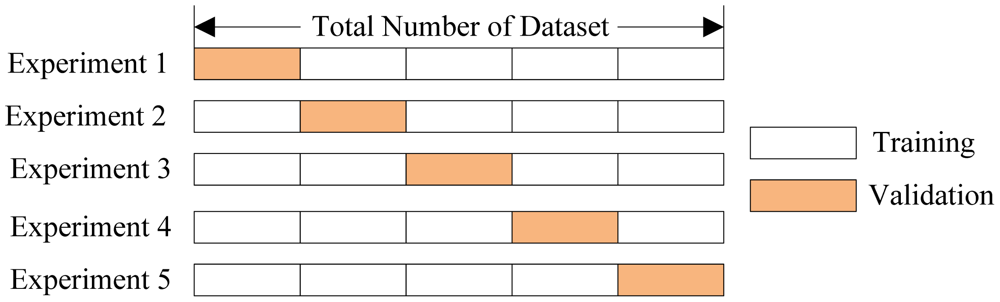


Additionaly, we will use grid search for the fine-tunning of the models. 

## Random Search: we decide which parameters and how (randomly)

In [28]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [29]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 3, 5, 10], 'min_samples_leaf': [1, 2, 3, 4], 'bootstrap': [True, False]}


In [30]:
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 10, 
                               verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.6min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                             

In [31]:
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

In [32]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mae = 100 * np.mean(errors)
    print('Model Performance')
    print('Mean Absolute Error: {:0.4f}'.format(np.mean(errors)))
    return mae

#### Run base model


In [37]:
base_model = RandomForestRegressor(n_estimators = 1000, random_state = 4)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Mean Absolute Error: 0.8888


#### Compare fine-tunned model


In [34]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Mean Absolute Error: 0.8385


In [38]:
print('Improvement of {:0.2f}%.'.format( 100 * (base_accuracy - random_accuracy) / base_accuracy))

Improvement of 5.66%.


## Grid search: we decide which parameters and how (not randomly)

In [39]:
# Create the parameter grid 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 15, 20, 25, 30],
    'max_features': ['sqrt'],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [2, 3],
    'n_estimators': [500, 1000, 1500]
}

# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [40]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   54.9s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [41]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 500}

In [42]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Model Performance
Mean Absolute Error: 0.8381


In [43]:
print('Improvement of {:0.2f}%.'.format( 100 * (base_accuracy - grid_accuracy) / base_accuracy))

Improvement of 5.70%.
